# Подключаем библиотеки

In [270]:
import numpy as np
import pandas as pd
import fasttext.util
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from torch.autograd import Variable
from matplotlib import pyplot as plt
import spacy

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-12-26 15:21:43.497210: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 15:21:44.940967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 15:21:49.481446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-26 15:21:58.008938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call

# Данные

## Скачиваем датасет

In [196]:
train_data = pd.read_csv('SMS_train.csv',encoding='latin1')
test_data = pd.read_csv('SMS_test.csv',encoding='latin1')

In [198]:
X_train = np.array([train_data["Message_body"][i] for i in range(len(train_data))])
y_train = np.array([int(train_data["Label"][i] == "Spam")  for i in range(len(train_data))])
X_test = np.array([test_data["Message_body"][i] for i in range(len(test_data))])
y_test = np.array([int(test_data["Label"][i] == "Spam") for i in range(len(test_data))])

## Смотрим на датасет

Выбранный датасет представляет собой набор электронных писем, для каждого из которых известно является ли оно спамом.

Всего в обучающей выборке 957 сообщений, в тестовой - 125

In [197]:
train_data

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam
...,...,...,...
952,953,hows my favourite person today? r u workin har...,Non-Spam
953,954,How much you got for cleaning,Non-Spam
954,955,Sorry da. I gone mad so many pending works wha...,Non-Spam
955,956,Wat time ü finish?,Non-Spam


In [258]:
test_data

,S. No.,Message_body,Label
0,1,"UpgrdCentre Orange customer, you may now claim...",Spam
1,2,"Loan for any purpose £500 - £75,000. Homeowner...",Spam
2,3,Congrats! Nokia 3650 video camera phone is you...,Spam
3,4,URGENT! Your Mobile number has been awarded wi...,Spam
4,5,Someone has contacted our dating service and e...,Spam
...,...,...,...
120,121,7 wonders in My WORLD 7th You 6th Ur style 5th...,Non-Spam
121,122,Try to do something dear. You read something f...,Non-Spam
122,123,Sun ah... Thk mayb can if dun have anythin on....,Non-Spam
123,124,"SYMPTOMS when U are in love: ""1.U like listeni...",Non-Spam


Также посмотрим, что наблюдается сильный дизбаланс

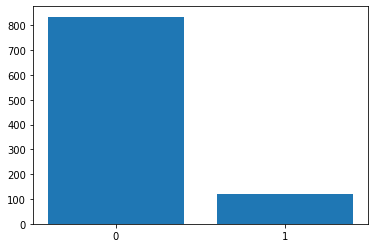

In [269]:
plt.bar([0, 1], [sum(y_train == 0), sum(y_train == 1)])
plt.xticks([0, 1])
plt.show()

## Примеры спам и не спам сообщений

In [200]:
count = 0
print("Spam examples:\n")
for i in range(X_train.shape[0]):
    if y_train[i] :
        print(X_train[i])
        print()
        count += 1
        if count == 5:
            break

count = 0
print("\n\nNot spam examples:\n")
for i in range(X_train.shape[0]):
    if not y_train[i] :
        print(X_train[i])
        print()
        count += 1
        if count == 5:
            break

Spam examples:

This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.

REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode

ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800

Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX

PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points. Call 08718738001 Identifier Code: 49557 Expires 26/11/04



Not spam examples:

Rofl. Its true to its name

The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free

Pity, * was in mood for that. So...any other suggestions?

Will ü b going to esplanade fr home?

Huh y lei..

# Чистка

In [271]:
nlp = spacy.load('en_core_web_sm')

In [272]:
def filter_text(text):
  res = []
  tokens = nlp(text)
  for token in tokens:
    if token.is_alpha and not token.is_stop:
      res.append(token.lemma_.lower())
  return ' '.join(res)

In [275]:
X_train = np.array([filter_text(str(x)) for x in X_train])

In [276]:
X_test = np.array([filter_text(str(x)) for x in X_test])

# Использование fasttext

## Скачиваем придобученные м-беддинги для русского языка

In [201]:
fasttext.util.download_model('ru', if_exists='ignore')

'cc.ru.300.bin'

In [279]:
ft = fasttext.load_model('cc.ru.300.bin')

Убедимся, что размерность действительно 300, как в названии

In [203]:
ft.get_dimension()

300

## Применяем fasttext к датасету

In [280]:
X_ft_train = np.array([ft[row] for row in X_train])
X_ft_train.shape

(957, 300)

In [281]:
X_ft_test = np.array([ft[row] for row in X_test])
X_ft_test.shape

(125, 300)

# Создаем DataLoader для дальнейшего использования

In [282]:
train_loader = DataLoader([(X_ft_train[i], y_train[i]) for i in range(X_ft_train.shape[0])], shuffle=True, batch_size=50)
test_loader = DataLoader([(X_ft_test[i], y_test[i]) for i in range(X_ft_test.shape[0])], shuffle=False, batch_size=50)

# Обучение ML-модели

В качестве ML-модели был выбран случайный лес с числом деревьев 100

In [283]:
model = RandomForestClassifier()

In [284]:
model.fit(X_ft_train, y_train)

RandomForestClassifier()

Увидим, что точность очень маленькая. Скорее всего это связано с тем, что в датасете представлено слишком мало примеров

In [285]:
model.score(X_ft_test, y_test)

0.504

## Обучение CNN

In [213]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

Зададим модель следующим образом

In [246]:
class CNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=6):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),

            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),

            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),

            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
        )
        self.cl = nn.Sequential(nn.Linear(hidden_size, num_classes)        )

    def forward(self, x):
        x = self.cnn(x.reshape(x.shape[0], x.shape[1], -1))
        prediction = self.cl(x)
        return prediction

In [287]:
model = CNNModel(X_ft_train.shape[1], 10)

learning_rate = 0.01
num_epochs = 20

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

total_time = 0

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start
    total_time += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_loader, model)}')
    print(f'    accuracy on test data : {get_accuracy(test_loader, model)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Epoch 0
    accuracy on train data : 0.8725183010101318
    accuracy on test data : 0.3919999897480011
    epoch_time = 0 min, 0 sec
Epoch 1
    accuracy on train data : 0.8725183010101318
    accuracy on test data : 0.3919999897480011
    epoch_time = 0 min, 0 sec
Epoch 2
    accuracy on train data : 0.8725183010101318
    accuracy on test data : 0.3919999897480011
    epoch_time = 0 min, 0 sec
Epoch 3
    accuracy on train data : 0.9352142214775085
    accuracy on test data : 0.5120000243186951
    epoch_time = 0 min, 0 sec
Epoch 4
    accuracy on train data : 0.9644722938537598
    accuracy on test data : 0.5440000295639038
    epoch_time = 0 min, 0 sec
Epoch 5
    accuracy on train data : 0.9696969985961914
    accuracy on test data : 0.5360000133514404
    epoch_time = 0 min, 0 sec
Epoch 6
    accuracy on train data : 0.9759665727615356
    accuracy on test data : 0.5440000295639038
    epoch_time = 0 min, 0 sec
Epoch 7
    accuracy on train data : 0.9791013598442078
    accuracy 

# Выводы

Даже с использованием CNN точность оказалась очень плохой. Всего 55% на тестовой выборке. Возможно, это связано с тем, что данных слишком мало.

Но можно сказать что классификация возможна, если использовать датасет с большим количеством примеров.